<a href="https://colab.research.google.com/github/mdeniz1/datascienceprojects/blob/main/attribute_modelling_on_google_analytics_4_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I trained catboost model architecture with google analytics 4 data for predictive analysis of customer online advertisement engagemet.

I used publicly available ga4 data which is accessiblee through BigQuery. I first retrieved all the 60 tables using a wild card table. I then stored the table in my personal bigquery database and accessed it in this colab notebook.

after data cleaning and

In [ ]:
!pip install shap


In [ ]:
!pip install catboost

In [69]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
#from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import joblib
#import shap
import matplotlib.pyplot as plt

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project='eng-wharf-410711')


df = client.query('''
  SELECT
  *
FROM `eng-wharf-410711.ga4.ga4_table`
limit 1500000
''').to_dataframe()


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
path = '/content/drive/My Drive/df_ga4_2.pkl'
df1=pd.read_pickle(path)

In [ ]:
#path = '/content/drive/My Drive/df_ga4_2.pkl'
#df.to_pickle(path)


In [10]:
df=df1.copy()

In [6]:
df['event_bundle_sequence_id'].nunique()

1302127

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 23 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   event_date                     1500000 non-null  object 
 1   event_timestamp                1500000 non-null  Int64  
 2   event_name                     1500000 non-null  object 
 3   event_params                   1500000 non-null  object 
 4   event_previous_timestamp       0 non-null        Int64  
 5   event_value_in_usd             1833 non-null     float64
 6   event_bundle_sequence_id       1500000 non-null  Int64  
 7   event_server_timestamp_offset  0 non-null        Int64  
 8   user_id                        0 non-null        object 
 9   user_pseudo_id                 1500000 non-null  object 
 10  privacy_info                   1500000 non-null  object 
 11  user_properties                1500000 non-null  object 
 12  user_first_tou

In [5]:
df.head()

,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,privacy_info,user_properties,user_first_touch_timestamp,user_ltv,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions,ecommerce,items
0,20201110,1604971820344522,begin_checkout,"[{'key': 'clean_event', 'value': {'string_valu...",<NA>,NaN,1752648042,<NA>,None,21732519.8875634255,"{'analytics_storage': None, 'ads_storage': Non...",[],1604969882342411,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Africa', 'sub_continent': 'Nort...",None,"{'medium': 'referral', 'name': '(referral)', '...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
1,20210120,1611105762299838,page_view,"[{'key': 'page_location', 'value': {'string_va...",<NA>,NaN,3046368137,<NA>,None,8079006.6650182195,"{'analytics_storage': None, 'ads_storage': Non...",[],1610778647214866,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '(none)', 'name': '(direct)', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
2,20210119,1611048922509453,view_item,"[{'key': 'page_title', 'value': {'string_value...",<NA>,NaN,-3130684596,<NA>,None,24467430.7181196119,"{'analytics_storage': None, 'ads_storage': Non...",[],1611048875682334,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '<Other>', 'name': '<Other>', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...","[{'item_id': 'GGOEGOCJ093999', 'item_name': 'G..."
3,20201212,1607757908307933,user_engagement,"[{'key': 'debug_mode', 'value': {'string_value...",<NA>,NaN,1763954426,<NA>,None,8135710.8287882373,"{'analytics_storage': None, 'ads_storage': Non...",[],1607757872095164,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'A...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '(none)', 'name': '(direct)', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
4,20210125,1611551863121673,page_view,"[{'key': 'page_referrer', 'value': {'string_va...",<NA>,NaN,3622512011,<NA>,None,4258423.8896454000,"{'analytics_storage': None, 'ads_storage': Non...",[],1611551858110729,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'X...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]


In [6]:
df.drop(['app_info', 'event_dimensions', 'event_server_timestamp_offset', 'user_id', 'event_previous_timestamp',
'event_timestamp', 'user_properties','user_first_touch_timestamp', 'stream_id',#'event_bundle_sequence_id'
], axis=1, inplace=True)

In [ ]:
df.head()

In [14]:
df['user_pseudo_id'].nunique()


244395

I group unique users with event dates to create unique sessions.

In [7]:
df['event_date'] = pd.to_datetime(df['event_date'])

# Sort the DataFrame by 'event_date' and 'user_pseudo_id'
df = df.sort_values(['event_date', 'user_pseudo_id'])

# Convert 'event_date' column to datetime

# Group the DataFrame
grouped = df.groupby(['event_date', 'user_pseudo_id'])

# Filter out groups with less than 4 rows
filtered_groups = grouped.filter(lambda x: len(x) >= 4)
filtered_groups.reset_index(drop=True, inplace=True)

In [8]:
# Create a new column 'n_engagements' and initialize it with 0
filtered_groups['n_engagements'] = 0

# Iterate over each group
for name, group in filtered_groups.groupby(['event_date', 'user_pseudo_id']):
    # Get the total number of members in the group
    group_size = len(group)

    # Iterate over each row in the group in reverse order
    for i, row in enumerate(group[::-1].itertuples(), start=1):
        # Calculate the value to be assigned to 'n_engagements'
        value = group_size - i+1

        # Assign the value to the corresponding row in the 'n_engagements' column
        filtered_groups.loc[row.Index, 'n_engagements'] = value

In [9]:
filtered_groups.head(5)

,event_date,event_name,event_params,event_value_in_usd,event_bundle_sequence_id,user_pseudo_id,privacy_info,user_ltv,device,geo,traffic_source,platform,ecommerce,items,n_engagements
0,2020-11-01,user_engagement,"[{'key': 'source', 'value': {'string_value': '...",NaN,-2628586713,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[],1
1,2020-11-01,session_start,"[{'key': 'ga_session_number', 'value': {'strin...",NaN,-1341154570,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[],2
2,2020-11-01,user_engagement,"[{'key': 'debug_mode', 'value': {'string_value...",NaN,7038273736,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[],3
3,2020-11-01,view_promotion,"[{'key': 'all_data', 'value': {'string_value':...",NaN,20088199,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[],4
4,2020-11-01,page_view,"[{'key': 'all_data', 'value': {'string_value':...",NaN,-3423414439,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[],5


here I check whether there are unique sessions within each user-event date group. There are two candidates for this check: stream_id and event_bundle_sequence_id. I start with checking value counts of each column

In [11]:
df['stream_id'].value_counts()

2100450278    1500000
Name: stream_id, dtype: Int64

There are only one value in stream_id so it does not offer any further knowdledge.

In [14]:
df['event_bundle_sequence_id'].nunique()

1302127

as there are repeating event_bundle_sequence_id, I will further check the column values.

In [ ]:

groups = df.groupby('event_bundle_sequence_id')

grouped_dfs = groups.filter(lambda x: len(x) > 1)

In [8]:
grouped_dfs.sort_values('event_bundle_sequence_id', inplace=True)


In [10]:
path = '/content/drive/My Drive/grouped_dfs_ga4.pkl'
grouped_dfs.to_pickle(path)


In [9]:
grouped_dfs.head()

,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,privacy_info,user_properties,user_first_touch_timestamp,user_ltv,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions,ecommerce,items
1223563,20201110,1605037157335826,scroll,"[{'key': 'page_location', 'value': {'string_va...",<NA>,NaN,-9999940514,<NA>,None,73631766.1438326419,"{'analytics_storage': None, 'ads_storage': Non...",[],1605037131077816,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'A...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
799546,20201110,1605037157335826,page_view,"[{'key': 'page_location', 'value': {'string_va...",<NA>,NaN,-9999940514,<NA>,None,73631766.1438326419,"{'analytics_storage': None, 'ads_storage': Non...",[],1605037131077816,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'A...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
470479,20201118,1605685045827463,first_visit,"[{'key': 'ga_session_id', 'value': {'string_va...",<NA>,NaN,-9999933101,<NA>,None,8952049.1195785499,"{'analytics_storage': None, 'ads_storage': Non...",[],1605685045827463,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
468993,20201118,1605685045827463,page_view,"[{'key': 'page_title', 'value': {'string_value...",<NA>,NaN,-9999933101,<NA>,None,8952049.1195785499,"{'analytics_storage': None, 'ads_storage': Non...",[],1605685045827463,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
1247398,20210128,1611800903289441,page_view,"[{'key': 'ga_session_number', 'value': {'strin...",<NA>,NaN,-9999867379,<NA>,None,38067757.0522298514,"{'analytics_storage': None, 'ads_storage': Non...",[],1611137723793504,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'A...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': 'referral', 'name': '(referral)', '...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]


when I check both the grouped and non grouped data frames basen on event_bundle_sequence_id, I see no repeating pattern for each event-date user_psuedo_id groups. so I also delete this column for its irregular values.

In [45]:
df_grouped=filtered_groups.copy()

In [ ]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147914 entries, 0 to 1147913
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   event_date          1147914 non-null  datetime64[ns]
 1   event_name          1147914 non-null  object        
 2   event_params        1147914 non-null  object        
 3   event_value_in_usd  1831 non-null     float64       
 4   user_pseudo_id      1147914 non-null  object        
 5   privacy_info        1147914 non-null  object        
 6   user_ltv            1147914 non-null  object        
 7   device              1147914 non-null  object        
 8   geo                 1147914 non-null  object        
 9   traffic_source      1147914 non-null  object        
 10  platform            1147914 non-null  object        
 11  ecommerce           1147914 non-null  object        
 12  items               1147914 non-null  object        
 13  n_engagement

Analysis below shows that there are 144 row that are recorded as 'purchase'but without any value in usd. I take this as an error in data preparation but keep these rows assuming the data labeler omitted filling event_value_in_usd column in 144 events. I will use a transformed version of event_name column as the target column to be feed into the model. That is why, these omitted values will not make any problem in model building.

In [21]:
df_purchase=df_grouped[df_grouped['event_name']=='purchase']
df_purchase.info()

1975
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 2233 to 1145809
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   event_date                1975 non-null   datetime64[ns]
 1   event_name                1975 non-null   object        
 2   event_params              1975 non-null   object        
 3   event_value_in_usd        1831 non-null   float64       
 4   event_bundle_sequence_id  1975 non-null   Int64         
 5   user_pseudo_id            1975 non-null   object        
 6   privacy_info              1975 non-null   object        
 7   user_ltv                  1975 non-null   object        
 8   device                    1975 non-null   object        
 9   geo                       1975 non-null   object        
 10  traffic_source            1975 non-null   object        
 11  platform                  1975 non-null   object        
 12  ecommerce

In [ ]:
df1=df_grouped[df_grouped['event_value_in_usd']>0]
df1['event_name'].value_counts()

purchase    1831
Name: event_name, dtype: int64

In [22]:
df_grouped['event_value_in_usd'] = df_grouped['event_value_in_usd'].fillna(0)

In [ ]:
df_grouped.head()

,event_date,event_name,event_params,event_value_in_usd,event_bundle_sequence_id,user_pseudo_id,privacy_info,user_ltv,device,geo,traffic_source,platform,ecommerce,items
0,2020-11-01,user_engagement,"[{'key': 'source', 'value': {'string_value': '...",0.0,-2628586713,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[]
1,2020-11-01,session_start,"[{'key': 'ga_session_number', 'value': {'strin...",0.0,-1341154570,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[]
2,2020-11-01,user_engagement,"[{'key': 'debug_mode', 'value': {'string_value...",0.0,7038273736,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[]
3,2020-11-01,view_promotion,"[{'key': 'all_data', 'value': {'string_value':...",0.0,20088199,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[]
4,2020-11-01,page_view,"[{'key': 'all_data', 'value': {'string_value':...",0.0,-3423414439,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[]


In [ ]:
#as seen below, platform variable has a constant value which means we can delete it
df_grouped['platform'].value_counts()

WEB    1147914
Name: platform, dtype: int64

In [46]:
df_grouped.drop(['platform'], axis=1, inplace= True )

In [47]:
df_grouped.drop(['items'], axis=1, inplace= True )#item column also has a constant value.

here I decompose columns with dictionaries to by creating two new features with the key names of these dictionaries.  

In [48]:
df_grouped['medium'] = df['traffic_source'].apply(lambda x: x['medium'])
df_grouped['name'] = df['traffic_source'].apply(lambda x: x['name'])

# Delete the 'traffic_source' column
df_grouped = df_grouped.drop('traffic_source', axis=1)


In [49]:
df_grouped['analytics_storage'] = df['privacy_info'].apply(lambda x: x['analytics_storage'])
df_grouped['ads_storage'] = df['privacy_info'].apply(lambda x: x['ads_storage'])

# Delete the 'traffic_source' column
df_grouped = df_grouped.drop('privacy_info', axis=1)


In [50]:
print(df_grouped['analytics_storage'].value_counts())
print(df_grouped['ads_storage'].value_counts())

Series([], Name: analytics_storage, dtype: int64)
Series([], Name: ads_storage, dtype: int64)


In [51]:
df_grouped = df_grouped.drop('analytics_storage', axis=1)
df_grouped = df_grouped.drop('ads_storage', axis=1)


In [52]:
df_grouped['category'] = df['device'].apply(lambda x: x['category'])
df_grouped['mobile_brand_name'] = df['device'].apply(lambda x: x['mobile_brand_name'])

# Delete the 'traffic_source' column
df_grouped = df_grouped.drop('device', axis=1)


In [53]:
df_grouped['revenue'] = df['user_ltv'].apply(lambda x: x['revenue'])
df_grouped['currency'] = df['user_ltv'].apply(lambda x: x['currency'])

# Delete the 'traffic_source' column
df_grouped = df_grouped.drop('user_ltv', axis=1)


In [54]:
df_grouped['continent'] = df['geo'].apply(lambda x: x['continent'])
df_grouped['sub_continent'] = df['geo'].apply(lambda x: x['sub_continent'])

# Delete the 'traffic_source' column
df_grouped = df_grouped.drop('geo', axis=1)


In [55]:
df_grouped['total_item_quantity'] = df['ecommerce'].apply(lambda x: x['total_item_quantity'])
df_grouped['purchase_revenue'] = df['ecommerce'].apply(lambda x: x['purchase_revenue'])

# Delete the 'traffic_source' column
df_grouped = df_grouped.drop('ecommerce', axis=1)


In [56]:
#event_params also does not seem to reveal important information. so I delete it.
df_grouped = df_grouped.drop('event_params', axis=1)


In [58]:
df_grouped.head(5)

,event_date,event_name,event_value_in_usd,event_bundle_sequence_id,user_pseudo_id,n_engagements,medium,name,category,mobile_brand_name,revenue,currency,continent,sub_continent,total_item_quantity,purchase_revenue
0,2020-11-01,user_engagement,NaN,-2628586713,1013442.5000387623,1,referral,(referral),desktop,Google,0.0,USD,Africa,Northern Africa,NaN,NaN
1,2020-11-01,session_start,NaN,-1341154570,1013442.5000387623,2,(none),(direct),mobile,Samsung,0.0,USD,Americas,Northern America,NaN,NaN
2,2020-11-01,user_engagement,NaN,7038273736,1013442.5000387623,3,<Other>,<Other>,desktop,Google,0.0,USD,Americas,Northern America,NaN,NaN
3,2020-11-01,view_promotion,NaN,20088199,1013442.5000387623,4,(none),(direct),mobile,Apple,0.0,USD,Americas,Northern America,NaN,NaN
4,2020-11-01,page_view,NaN,-3423414439,1013442.5000387623,5,organic,(organic),mobile,Xiaomi,0.0,USD,Americas,Northern America,NaN,NaN


In [60]:
df_grouped = df_grouped.drop(['total_item_quantity', 'event_value_in_usd', 'purchase_revenue', 'event_bundle_sequence_id','event_bundle_sequence_id'], axis=1)


**Feature Engineering**


here I create three new features out of the existing event_name feature. each of the last three clicks before the last event of each session will be stored as a feature in the dataset.

In [61]:
df_grouped['event_name_L1'] = df_grouped.groupby(['event_date', 'user_pseudo_id'])['event_name'].shift(1)
df_grouped['event_name_L2'] = df_grouped.groupby(['event_date', 'user_pseudo_id'])['event_name'].shift(2)
df_grouped['event_name_L3'] = df_grouped.groupby(['event_date', 'user_pseudo_id'])['event_name'].shift(3)


In [36]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147914 entries, 0 to 1147913
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   event_date          1147914 non-null  datetime64[ns]
 1   event_name          1147914 non-null  object        
 2   event_value_in_usd  1147914 non-null  float64       
 3   user_pseudo_id      1147914 non-null  object        
 4   n_engagements       1147914 non-null  int64         
 5   medium              1147914 non-null  object        
 6   name                1147914 non-null  object        
 7   category            1147914 non-null  object        
 8   mobile_brand_name   1147914 non-null  object        
 9   revenue             1147914 non-null  float64       
 10  currency            1147914 non-null  object        
 11  continent           1147914 non-null  object        
 12  sub_continent       1147914 non-null  object        
 13  event_name_L

In [62]:
df_grouped.dropna(inplace=True)


In [63]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865683 entries, 3 to 1147913
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   event_date         865683 non-null  datetime64[ns]
 1   event_name         865683 non-null  object        
 2   user_pseudo_id     865683 non-null  object        
 3   n_engagements      865683 non-null  int64         
 4   medium             865683 non-null  object        
 5   name               865683 non-null  object        
 6   category           865683 non-null  object        
 7   mobile_brand_name  865683 non-null  object        
 8   revenue            865683 non-null  float64       
 9   currency           865683 non-null  object        
 10  continent          865683 non-null  object        
 11  sub_continent      865683 non-null  object        
 12  event_name_L1      865683 non-null  object        
 13  event_name_L2      865683 non-null  object 

In [ ]:
df_grouped.head(100)

In [39]:
df_grouped['currency'].value_counts()

USD    865683
Name: currency, dtype: int64

In [64]:
df_grouped.drop(['currency'], axis=1, inplace= True )

now we can also delete event_date, user_pseudo_id columns and event_value_in_usd

In [65]:
df_grouped.drop(['user_pseudo_id','event_date','revenue'], axis=1, inplace= True )

In [66]:
df_grouped.head()

,event_name,n_engagements,medium,name,category,mobile_brand_name,continent,sub_continent,event_name_L1,event_name_L2,event_name_L3
3,view_promotion,4,(none),(direct),mobile,Apple,Americas,Northern America,user_engagement,session_start,user_engagement
4,page_view,5,organic,(organic),mobile,Xiaomi,Americas,Northern America,view_promotion,user_engagement,session_start
5,first_visit,6,organic,(organic),desktop,Apple,Europe,Northern Europe,page_view,view_promotion,user_engagement
9,page_view,4,<Other>,<Other>,mobile,Samsung,Africa,Northern Africa,page_view,scroll,first_visit
10,user_engagement,5,(data deleted),(data deleted),mobile,Apple,Asia,Southeast Asia,page_view,page_view,scroll


There are 17 different events in event_name column. Purchase is the desired outcome and it is stored in event_name column. The desired outcome is the purchase event. So I choose purchase as the target and label it as 1 and leave others as 0.

In [67]:
# prompt: out of event_name columns, create a new colum with the name 'purchase' and write 1 if the event is 'purchase' otherwise 0

df_grouped['purchase'] = df_grouped['event_name'].apply(lambda x: 1 if x=='purchase' else 0)
df_grouped.drop('event_name', axis=1, inplace=True)

In [73]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865683 entries, 3 to 1147913
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   n_engagements      865683 non-null  int64 
 1   medium             865683 non-null  object
 2   name               865683 non-null  object
 3   category           865683 non-null  object
 4   mobile_brand_name  865683 non-null  object
 5   continent          865683 non-null  object
 6   sub_continent      865683 non-null  object
 7   event_name_L1      865683 non-null  object
 8   event_name_L2      865683 non-null  object
 9   event_name_L3      865683 non-null  object
 10  purchase           865683 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 79.3+ MB


**Visualization of major features**

Except engagement feature, all the features are categorical. I will first check the target 'purchase' feature to observe a possible imbalance.

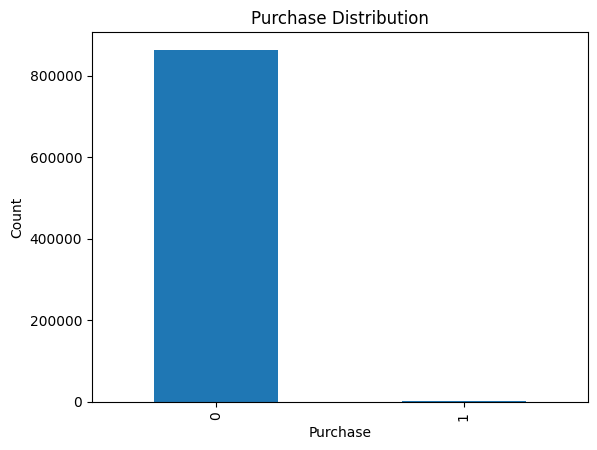

In [72]:
#as seen below, purchase distribution is highly imbalanced
df_grouped['purchase'].value_counts().plot(kind='bar')

plt.title('Purchase Distribution')
plt.xlabel('Purchase')
plt.ylabel('Count')

plt.show()

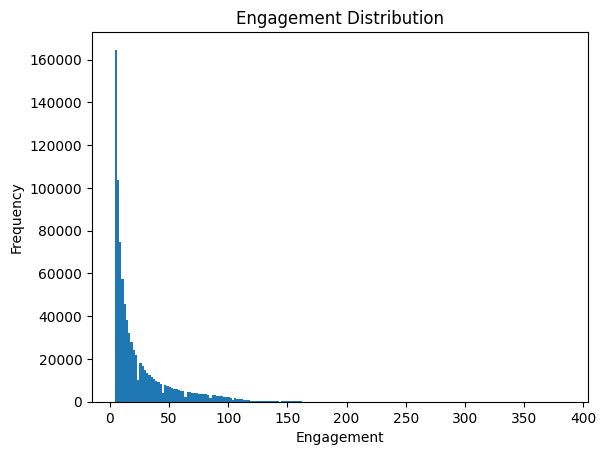

In [81]:
df_grouped['n_engagements'].plot(kind='hist', bins=200)

# Set the plot title and axis labels
plt.title('Engagement Distribution')
plt.xlabel('Engagement')
plt.ylabel('Frequency')

# Display the plot
plt.show()


majority of the engagements are smaller than 10.

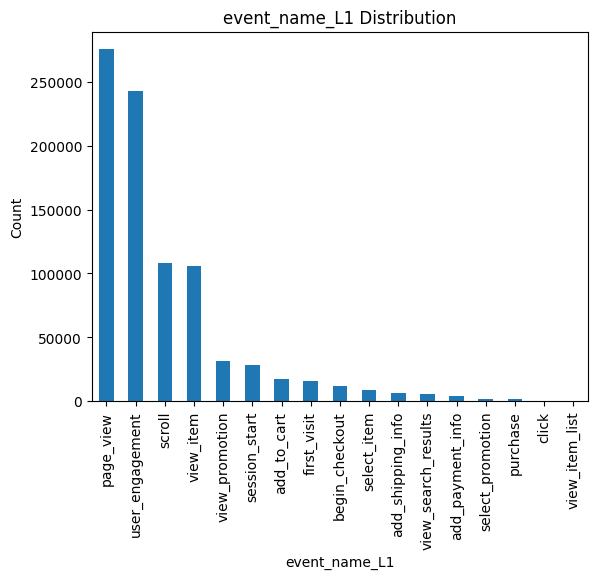

In [82]:
#as seen below, purchase distribution is highly imbalanced
df_grouped['event_name_L1'].value_counts().plot(kind='bar')

plt.title('event_name_L1 Distribution')
plt.xlabel('event_name_L1')
plt.ylabel('Count')

plt.show()

majority of the engagements are page_views and scroll. notably, very few of them are purchase

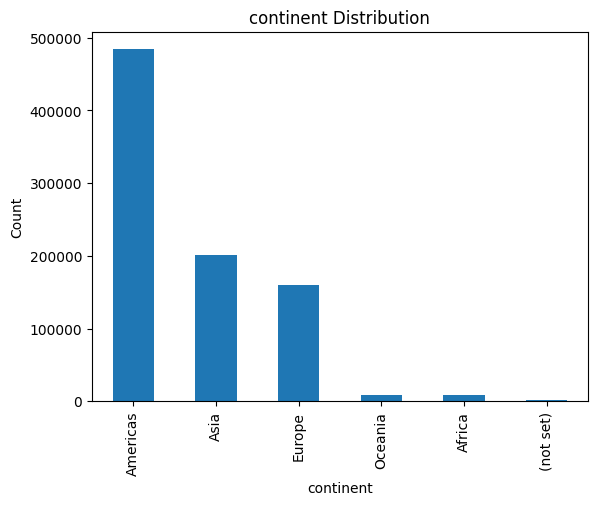

In [84]:
#as seen below, purchase distribution is highly imbalanced
df_grouped['continent'].value_counts().plot(kind='bar')

plt.title('continent Distribution')
plt.xlabel('continent')
plt.ylabel('Count')

plt.show()

Americas dominate the continent representation followed by Asia and Europe

In [ ]:
path = '/content/drive/My Drive/df_grouped_ga4.pkl'
df_grouped.to_pickle(path)


In [ ]:
path = '/content/drive/My Drive/df_grouped_ga4.pkl'
df_grouped=pd.read_pickle(path)

**Predicting Model Building with Catboost**

I will build a catboost model for attribution modelling. My purpose is to understand which features are importont in predicting the 'purchase' event.

* Test-Train Split

In [ ]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865683 entries, 3 to 1147913
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   n_engagements      865683 non-null  int64   
 1   medium             865683 non-null  category
 2   name               865683 non-null  category
 3   category           865683 non-null  category
 4   mobile_brand_name  865683 non-null  category
 5   continent          865683 non-null  category
 6   sub_continent      865683 non-null  category
 7   event_name_L1      865683 non-null  category
 8   event_name_L2      865683 non-null  category
 9   event_name_L3      865683 non-null  category
 10  purchase           865683 non-null  category
dtypes: category(10), int64(1)
memory usage: 21.5 MB


In [ ]:
df_grouped=df_grouped.astype('category')
df_grouped['n_engagements']=df_grouped['n_engagements'].astype('int')

In [ ]:
X = df_grouped.drop('purchase', axis=1)
y = df_grouped['purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
categorical_features = ['name', 'category', 'mobile_brand_name', 'continent', 'sub_continent',
                        'event_name_L1', 'event_name_L2', 'event_name_L3', 'medium']


In [ ]:

params = {
    'iterations': [ 500, 600],
    'depth': [ 8, 10,12],
    'learning_rate': [ 0.05,0.01],
    'l2_leaf_reg': [1, 3, 5],
    'auto_class_weights': ['Balanced']

}

cv = StratifiedKFold(n_splits=2)

clf = CatBoostClassifier(cat_features=categorical_features, task_type='GPU')
search1 = RandomizedSearchCV(clf, param_distributions=params, n_iter=8, cv=cv, scoring='recall')
search1.fit(X_train, y_train)

In [ ]:

best_estimator = search1.best_estimator_

# Training set
y_train_pred = best_estimator.predict(X_train)
train_recall_score = recall_score(y_train, y_train_pred)

# Cross-validation
cv_result = search1.best_score_

# Test set
y_pred = best_estimator.predict(X_test)
test_recall_score = recall_score(y_test, y_pred)

print(f"Train F1 Score: {train_recall_score:.2f}")
print(f"Mean CV F1 Score: {cv_result:.2f}")
print(f"Test F1 Score: {test_recall_score:.2f}")

print("Best Parameters:", search1.best_params_)

Train F1 Score: 0.78
Mean CV F1 Score: 0.21
Test F1 Score: 0.46
Best Parameters: {'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 600, 'depth': 8, 'auto_class_weights': 'Balanced'}


In [ ]:

params = {
    'iterations': [ 600,700],
    'depth': [ 8, 6],
    'learning_rate': [0.01, 0.005],
    'l2_leaf_reg': [ 5,6],
    'auto_class_weights': ['Balanced']

}

cv = StratifiedKFold(n_splits=2)

clf = CatBoostClassifier(cat_features=categorical_features, task_type='GPU')
search2 = RandomizedSearchCV(clf, param_distributions=params, n_iter=8, cv=cv, scoring='recall')
search2.fit(X_train, y_train)

In [ ]:

best_estimator = search2.best_estimator_

# Training set
y_train_pred = best_estimator.predict(X_train)
train_recall_score = recall_score(y_train, y_train_pred)

# Cross-validation
cv_result = search2.best_score_

# Test set
y_pred = best_estimator.predict(X_test)
test_recall_score = recall_score(y_test, y_pred)

print(f"Train F1 Score: {train_recall_score:.2f}")
print(f"Mean CV F1 Score: {cv_result:.2f}")
print(f"Test F1 Score: {test_recall_score:.2f}")

print("Best Parameters:", search2.best_params_)

Train F1 Score: 0.75
Mean CV F1 Score: 0.64
Test F1 Score: 0.69
Best Parameters: {'learning_rate': 0.005, 'l2_leaf_reg': 6, 'iterations': 600, 'depth': 6, 'auto_class_weights': 'Balanced'}


After several experiments, two of which I show here, I have created a good enough model which performs in similar performance for the test data as it does for the training data

**Analysis of feature importance with Shap Values**

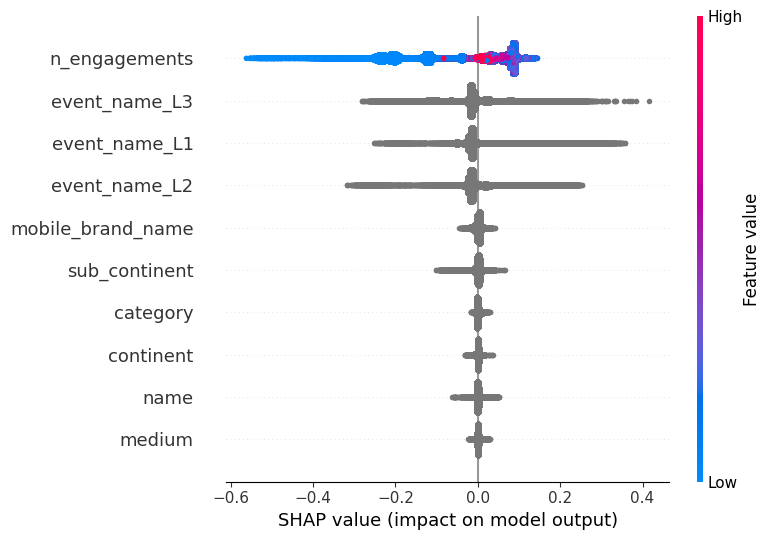

In [ ]:
explainer = shap.Explainer(best_estimator)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)




Four features emerge as the most important features. These four features cause the biggest impact for the model's predictions. In the order of importance these are:

1. n_engagements
2. event_name_1
3. event_name_2
4. event_name_3

These four features help us to understand which channels are the most important in understanding the customer's ad journey for a purchase.

The most important feature is the number of engagements. As the engagements decrease, the possibility of purchase  also decreases. while an increase in engagements do not always increase the purchase outcome, still in majority of the cases there increase in engagements created the purchase outcome.

Each of the last three engagements are also quite important in endangering the purchase evet. however, all of these features are categorical. That is why, I will visualize how different events in these clicks are associated with the purchase and non-purchase outcome.



In [86]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865683 entries, 3 to 1147913
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   n_engagements      865683 non-null  int64 
 1   medium             865683 non-null  object
 2   name               865683 non-null  object
 3   category           865683 non-null  object
 4   mobile_brand_name  865683 non-null  object
 5   continent          865683 non-null  object
 6   sub_continent      865683 non-null  object
 7   event_name_L1      865683 non-null  object
 8   event_name_L2      865683 non-null  object
 9   event_name_L3      865683 non-null  object
 10  purchase           865683 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 79.3+ MB


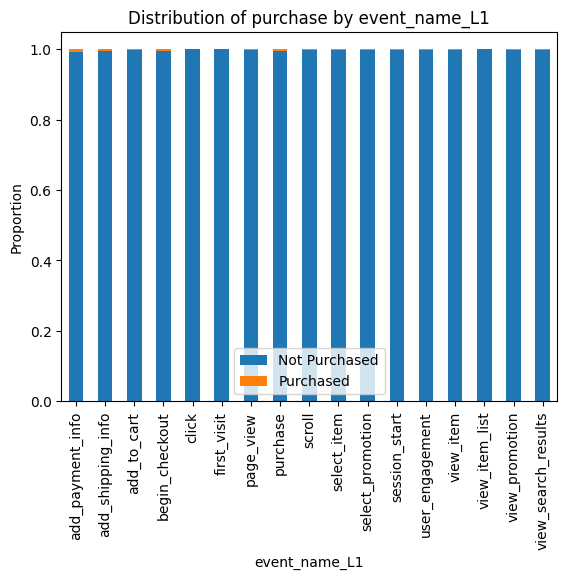

In [87]:
import matplotlib.pyplot as plt

# Calculate the distribution of 'purchase' for each unique value in 'event_name_L1'
grouped_counts = df_grouped.groupby('event_name_L1')['purchase'].value_counts().unstack()

# Normalize the counts to get proportions
grouped_props = grouped_counts.div(grouped_counts.sum(axis=1), axis=0)

# Plot the stacked bar plot
grouped_props.plot(kind='bar', stacked=True)
plt.xlabel('event_name_L1')
plt.ylabel('Proportion')
plt.title('Distribution of purchase by event_name_L1')
plt.legend(['Not Purchased', 'Purchased'])
plt.show()

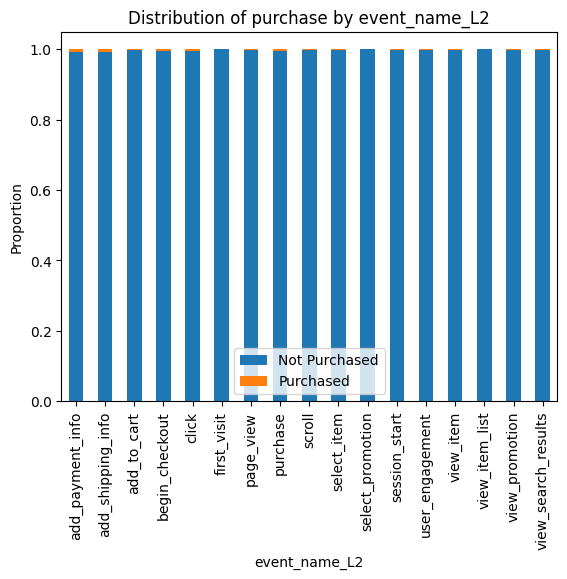

In [88]:
import matplotlib.pyplot as plt

# Calculate the distribution of 'purchase' for each unique value in 'event_name_L1'
grouped_counts = df_grouped.groupby('event_name_L2')['purchase'].value_counts().unstack()

# Normalize the counts to get proportions
grouped_props = grouped_counts.div(grouped_counts.sum(axis=1), axis=0)

# Plot the stacked bar plot
grouped_props.plot(kind='bar', stacked=True)
plt.xlabel('event_name_L2')
plt.ylabel('Proportion')
plt.title('Distribution of purchase by event_name_L2')
plt.legend(['Not Purchased', 'Purchased'])
plt.show()

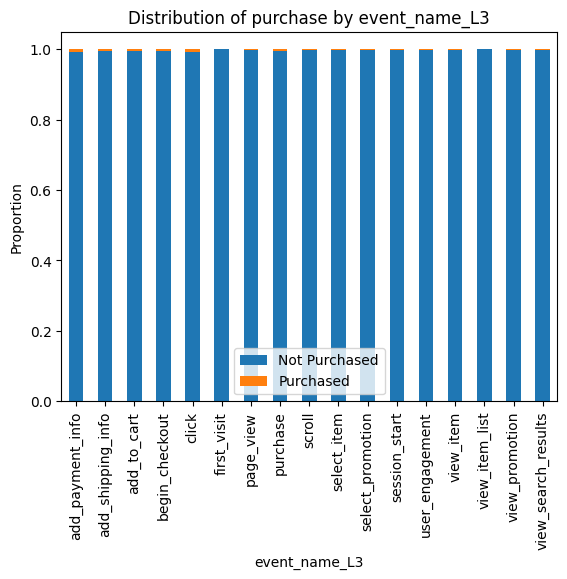

In [89]:
import matplotlib.pyplot as plt

# Calculate the distribution of 'purchase' for each unique value in 'event_name_L1'
grouped_counts = df_grouped.groupby('event_name_L3')['purchase'].value_counts().unstack()

# Normalize the counts to get proportions
grouped_props = grouped_counts.div(grouped_counts.sum(axis=1), axis=0)

# Plot the stacked bar plot
grouped_props.plot(kind='bar', stacked=True)
plt.xlabel('event_name_L3')
plt.ylabel('Proportion')
plt.title('Distribution of purchase by event_name_L3')
plt.legend(['Not Purchased', 'Purchased'])
plt.show()

As revealed in stacked bar charts,
in all the last three events before the last purchase event, 5 events emerge as the important ones to predict the purchase incidence. These are add_payment_info, add_shipping_info, add_to_cart, previous purchase and begin_checkout events. if any of these are present in especially the last click(the one with the highest shap value), the customer has a higher chances of making a purchase.